# Описание
Этот ноутбук содержит решение девятого домашнего задания "Регрессионный анализ"

## Результаты
1. Написана полностью
2. Написана полностью
3. Написана полностью
4. Написана полностью
5. -

## Материалы:

* [Условие задач](mspsdz9.pdf)
* [лекция](msps20208.pdf)

# Setup

## Library import
We import all the required Python libraries

In [53]:
# Data manipulation
import pandas as pd
import numpy as np

import scipy.stats as sps
from scipy.optimize import minimize

import matplotlib.pyplot as plt

import seaborn

from collections import Counter

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_regression

# Решения

## Задача 1

* Нам нужно решить задачу поиска условного экстремума при условии связи:

$$\begin{cases}
   ||Y-\theta||\rightarrow \min \\
   A\theta = 0
\end{cases}
$$

* Запишем Лагранжиан для данной задачи:

$$
L(\theta, \lambda) = ||Y-\theta|| + \lambda^T A\theta, \text{ где } \lambda \in \mathbb{R}^q 
$$

* Составим систему из производной Лагранжиана и условия связи:

$$\begin{cases}
    2(Y-\theta)+A^T\lambda =0\\
    A\theta = 0
\end{cases}
=
\begin{cases}
    A^T\lambda = 2\theta-2Y=0    & |A\cdot\\
    A\theta = 0
\end{cases}
=
\begin{cases}
    {AA}^T\lambda = 2A\theta-2AY\\
    A\theta = 0
\end{cases}
=
\begin{cases}
    {AA}^T\lambda = -2AY\\
    2(Y-\theta)+A^T\lambda =0
\end{cases}
=
\begin{cases}
    \lambda = -2({AA}^T)^{-1}AY\\
    2(Y-\theta)+A^T\lambda =0
\end{cases}
=
\begin{cases}
    \lambda = -2({AA}^T)^{-1}AY\\
    2Y-2A^T({AA}^T)^{-1}AY =2\theta
\end{cases}
=
\begin{cases}
    \lambda = -2({AA}^T)^{-1}AY\\
    \theta = (I-A^T({AA}^T)^{-1}A)Y
\end{cases}
$$

* Стоит сказать, что по методу множетелей лагранжа мы нашли точку возможного экстремума, но так она одна и функция непрерывна, то это точка локального минимума

---
## Задача 2
https://www.kaggle.com/c/msps-2020-hw9-2

* Загрузим данные

In [11]:
sample = pd.read_csv('data/msps-2020-hw9-2/Prostate_sample.csv')
data = pd.read_csv('data/msps-2020-hw9-2/Prostate_train_2020.csv')
test_mask = data.lpsa.isnull()
train_mask = ~test_mask

train = shuffle(data[train_mask])
test = data[test_mask]

X_train = train[train.columns[:-1]]  # drop lpsa
y_train = train[train.columns[-1]]

X_test = test[test.columns[:-1]]

* Изучим поближе признаки

In [12]:
X_train.head(5)

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
5,6,-1.049822,3.228826,50.0,-1.386294,0.0,-1.386294,6.0,0.0
58,59,0.542324,4.178226,70.0,0.438255,0.0,-1.386294,7.0,20.0
42,43,0.582216,3.865979,62.0,1.713798,0.0,-0.430783,6.0,0.0
86,87,2.024193,3.731699,58.0,1.638997,0.0,-1.386294,6.0,0.0
95,96,2.882564,3.773910,68.0,1.558145,1.0,1.558145,7.0,80.0


In [13]:
X_train.describe()

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,48.955882,1.296857,3.662554,64.750000,0.095459,0.220588,-0.231440,6.720588,25.882353
std,29.517227,1.240888,0.560431,7.446075,1.466132,0.417726,1.397490,0.709122,29.256217
min,1.000000,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000
25%,22.500000,0.462157,3.335726,61.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000
50%,46.500000,1.445491,3.601409,65.000000,0.085925,0.000000,-0.798508,7.000000,15.000000
75%,76.250000,2.318776,3.890793,69.000000,1.578358,0.000000,0.902861,7.000000,50.000000
max,96.000000,3.821004,6.104438,79.000000,2.326302,1.000000,2.656757,9.000000,100.000000


In [14]:
X_train.corr()

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
id,1.000000,0.706867,0.373677,0.240616,0.229101,0.561254,0.485164,0.343099,0.436108
lcavol,0.706867,1.000000,0.192575,0.284110,0.047271,0.595254,0.695478,0.434299,0.489382
lweight,0.373677,0.192575,1.000000,0.269543,0.437950,0.117641,0.077141,-0.047342,0.003836
age,0.240616,0.284110,0.269543,1.000000,0.285268,0.128360,0.171633,0.362522,0.273714
lbph,0.229101,0.047271,0.437950,0.285268,1.000000,-0.146360,-0.101008,0.015537,-0.044656
svi,0.561254,0.595254,0.117641,0.128360,-0.146360,1.000000,0.672958,0.311951,0.484561
lcp,0.485164,0.695478,0.077141,0.171633,-0.101008,0.672958,1.000000,0.482965,0.666253
gleason,0.343099,0.434299,-0.047342,0.362522,0.015537,0.311951,0.482965,1.000000,0.760264
pgg45,0.436108,0.489382,0.003836,0.273714,-0.044656,0.484561,0.666253,0.760264,1.000000


In [15]:
Counter(train.gleason).keys()

dict_keys([6.0, 7.0, 9.0, 8.0])

In [16]:
Counter(train.svi).keys()

dict_keys([0.0, 1.0])

In [17]:
Counter(train.pgg45).keys()

dict_keys([0.0, 20.0, 80.0, 5.0, 40.0, 25.0, 60.0, 70.0, 95.0, 50.0, 15.0, 30.0, 10.0, 75.0, 35.0, 100.0])

* **Выводы**

Заметим, что *gleason*, *svi* и *pgg45* - категориальные признаки. А так же сильно коррелирующих признаков нет

In [18]:
resample(X_train, y_train, n_samples=2*len(X_train))[0]

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
82,83,2.613007,3.888754,77.0,-0.527633,1.0,0.559616,7.0,30.0
59,60,1.061257,3.851211,61.0,1.294727,0.0,-1.386294,7.0,40.0
77,78,2.537657,4.354784,78.0,2.326302,0.0,-1.386294,7.0,10.0
51,52,1.660131,4.234831,64.0,2.073172,0.0,-1.386294,6.0,0.0
66,67,2.022871,3.878466,68.0,1.783391,0.0,1.321756,7.0,70.0
...,...,...,...,...,...,...,...,...,...
51,52,1.660131,4.234831,64.0,2.073172,0.0,-1.386294,6.0,0.0
81,82,2.513656,3.473518,57.0,0.438255,0.0,2.327278,7.0,60.0
77,78,2.537657,4.354784,78.0,2.326302,0.0,-1.386294,7.0,10.0
85,86,3.302849,3.518980,64.0,-1.386294,1.0,2.327278,7.0,60.0


* План **Решения**

Будем обучаться на бутстреповских выборках. Для каждой такой выборки будем заменять категориальные фичи на one-hot флаги. Далее с помощью LOO ищется лучшая *Lasso* регрессия. На ней предсказывается таргет. Далее усредняем таргет по всем выборкам

* Опишим метод для замены категориальных признаков на one-hot представления

In [19]:
def replace_categorial(X_train, X_test, cat_columns):
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    def one_hot_column(X, column_name, unique_values):
        X[column] = X[column].astype(pd.Categorical(unique_values))
        one_hotted = pd.get_dummies(X[column], prefix=column)
        X = pd.concat([X, one_hotted], axis=1)
        X.drop([column], axis=1, inplace=True)
        return X

    for column in cat_columns:
        unique_values = pd.unique(X_train[column])
        
        X_train = one_hot_column(X_train, column, unique_values)
        X_test = one_hot_column(X_test, column, unique_values)

    return X_train, X_test

In [570]:
A = pd.DataFrame({'country': ['russia', 'germany', 'australia','korea','germany']})
B = pd.DataFrame({'country': ['russia', 'germany', 'australia','korea','germany', 'italy']})
C = pd.DataFrame({'country': ['russia', 'germany', 'australia']})

replace_categorial(A, B, ['country'])[1]

,country_australia,country_germany,country_korea,country_russia
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0


In [571]:
replace_categorial(A, C, ['country'])[1]

,country_australia,country_germany,country_korea,country_russia
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0


* Опишем метод, предсказывающий *lpsa*, для train и test выборок, обучаясь на train

In [642]:
def fit_predict(X_train, y_train, X_test):
    """
    learn on X_train, y_train and predict y for train and test
    
    :param X_train: (pandas.Dataframe) train samples with id at first column
    :param y_train: (pandas.Dataframe) train target
    :param X_test: (pandas.Dataframe) test samples with id at first column
    
    :return 
        y_pred_train: (pandas.Dataframe) with two columns (id, lpsa)
        y_pred_test: (pandas.Dataframe) with two columns (id, lpsa)
    """
    n_samples = 20
    y_pred_train = np.zeros(len(X_train))
    y_pred_test = np.zeros(len(X_test))
    X_train, X_test = replace_categorial(X_train, X_test, ['gleason', 'svi', 'pgg45'])
    
    for _ in range(n_samples):
        scaler = StandardScaler()
        
        X_train_sampled, y_train_sampled = resample(X_train, y_train, n_samples=len(X_train))
        X_train_sampled_scaled = scaler.fit_transform(X_train_sampled)
        
        # find best model with LOO
        best_model = GridSearchCV(
            Lasso(),
            param_grid={'alpha': np.linspace(0.001, 2, 200)},
            cv=KFold(len(X_train_sampled_scaled)),
            scoring='neg_mean_squared_error'
        ).fit(X_train_sampled_scaled, y_train_sampled).best_estimator_
        
        
        X_train_scaled = scaler.fit_transform(X_train)
        y_pred_train += best_model.predict(X_train_scaled)
        X_test_scaled = scaler.transform(X_test)
        y_pred_test += best_model.predict(X_test_scaled)
   
    
    y_pred_train_df = pd.DataFrame()
    y_pred_train_df['id'] = X_train.id
    y_pred_train_df['lpsa'] = y_pred_train / n_samples
    
    y_pred_test_df = pd.DataFrame()
    y_pred_test_df['id'] = X_test.id
    y_pred_test_df['lpsa'] = y_pred_test / n_samples
    return y_pred_train_df, y_pred_test_df

* evaluate 

In [765]:
%%time
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.2)

y_pred_train, y_pred_test = fit_predict(X_train_train, y_train_train, X_train_test)
print('rmse on train is ', mean_squared_error(y_pred_train.lpsa, y_train_train)**.5)
print('rmse on test is ', mean_squared_error(y_pred_test.lpsa, y_train_test)**.5)

AttributeError: 'DataFrame' object has no attribute 'lpsa'

* Отправка решения

In [644]:
y_pred_train, y_pred_test = fit_predict(X_train, y_train, X_test)
ans = pd.concat([y_pred_train, y_pred_test]).sort_values('id')
ans.to_csv('kaggle_9_2.csv', index=False)
ans

,id,lpsa
0,1,0.480112
1,2,0.496295
2,3,0.368964
3,4,0.534917
4,5,0.810348
...,...,...
92,93,4.000528
93,94,4.369760
94,95,4.089036
95,96,4.714517


---
## Задача 3
https://www.kaggle.com/c/msps-2020-hw9-3

* Загрузим данные

In [722]:
sample = pd.read_csv('data/msps-2020-hw9-3/hw9t3_sample.csv')
data = pd.read_csv('data/msps-2020-hw9-3/hw9t3_train_2020.csv')
test_mask = data.duration.isnull()
train_mask = ~test_mask

train = shuffle(data[train_mask])
test = data[test_mask]

X_train = train[train.columns[:-1]]  # drop duration
y_train = train[train.columns[-1]]

X_test = test[test.columns[:-1]]

* Изучим поближе признаки

In [723]:
len(X_train)

378

In [724]:
X_train.head(5)

,id,Fadeev,Khaldeev,Pepermaldeev,kees,top hat,turtle,gloves,small cart,cardboard,...,desk,elefant,zeta function,Alla Pugachyova,soldering iron,frypan,drums,yellow submarine,sleep,mood
65,66,0,1,1,1,0,0,1,1,0,...,0,0,0,1,0,1,1,0,3.029829,apathic
35,36,0,0,1,1,1,1,0,0,0,...,0,0,0,1,0,1,1,1,3.500540,frivolous
386,387,0,0,1,0,1,0,1,0,1,...,1,0,1,0,1,0,0,1,3.617747,frivolous
482,483,0,0,1,1,0,1,1,1,1,...,1,0,0,1,0,0,1,0,3.160707,so-so
186,187,1,1,1,1,1,0,1,1,0,...,1,1,0,1,1,1,1,0,3.563624,moody


In [725]:
X_train.describe()

,id,Fadeev,Khaldeev,Pepermaldeev,kees,top hat,turtle,gloves,small cart,cardboard,...,Stanley cup,desk,elefant,zeta function,Alla Pugachyova,soldering iron,frypan,drums,yellow submarine,sleep
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,...,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,257.317460,0.309524,0.484127,0.616402,0.523810,0.555556,0.423280,0.510582,0.415344,0.375661,...,0.462963,0.505291,0.417989,0.423280,0.420635,0.386243,0.420635,0.494709,0.500000,3.138671
std,143.952743,0.462910,0.500410,0.486906,0.500095,0.497563,0.494734,0.500551,0.493434,0.484935,...,0.499287,0.500635,0.493882,0.494734,0.494315,0.487533,0.494315,0.500635,0.500663,0.454413
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.898288
25%,131.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.828491
50%,258.500000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,3.175231
75%,379.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.488819
max,500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.922278


In [726]:
X_train.describe(include=[np.int64])

,id,Fadeev,Khaldeev,Pepermaldeev,kees,top hat,turtle,gloves,small cart,cardboard,...,Coca-cola,Stanley cup,desk,elefant,zeta function,Alla Pugachyova,soldering iron,frypan,drums,yellow submarine
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,...,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,257.317460,0.309524,0.484127,0.616402,0.523810,0.555556,0.423280,0.510582,0.415344,0.375661,...,0.423280,0.462963,0.505291,0.417989,0.423280,0.420635,0.386243,0.420635,0.494709,0.500000
std,143.952743,0.462910,0.500410,0.486906,0.500095,0.497563,0.494734,0.500551,0.493434,0.484935,...,0.494734,0.499287,0.500635,0.493882,0.494734,0.494315,0.487533,0.494315,0.500635,0.500663
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,131.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,258.500000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,379.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


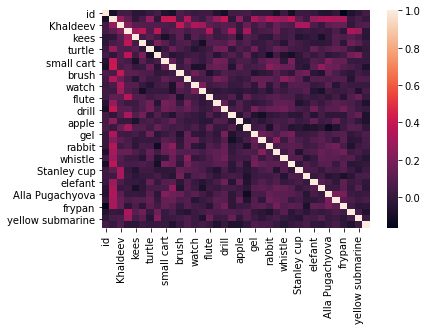

In [727]:
seaborn.heatmap(X_train.corr())
plt.show()

* **Выводы:**

Можно заметить, что 37 фичей раскладываются на *id*, 34 флага категорий, вещественный *sleep* и категориальный *mood*. Нет дубликатов, так как нет высокой попарной корреляции. Строк в 4 раза больше, чем в предыдущей задаче 

* **План решения:**

Почти всё готово, так как весь функционал определён во второй задаче. Но всё же кое-что нужно изменить:

1. Сначала так же заменяем категориальный признаки
2. Далее найдём оптимальные параметры для Ridge регрессии
3. И обучим несколько Ridge моделей на бутстреповских выборках. Результат усредним

* Заменим категориальный признак *mood*

In [728]:
X_train, X_test = replace_categorial(X_train, X_test, ['mood'])

* Найдём **alpha** для *Ridge* регрессии при помощи поиска по сетке с LOO валидацией

In [738]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

gs = GridSearchCV(
    Ridge(),
    param_grid={'alpha': np.linspace(0.001, 10, 1000)},
    cv=KFold(len(X_train_scaled)),
    scoring='neg_mean_squared_error',
    n_jobs=4
)
gs.fit(X_train_scaled, y_train)
print(f"Best alpha = {gs.best_params_['alpha']}")

Best alpha = 7.097387387387388


* Опишем метод, предсказывающий duration, для train и test выборок, обучаясь на train

In [934]:
def fit_predict(X_train, y_train, X_test):
    """
    learn on X_train, y_train and predict y for train and test
    
    :param X_train: (pandas.Dataframe) train samples with id at first column
    :param y_train: (pandas.Dataframe) train target
    :param X_test: (pandas.Dataframe) test samples with id at first column
    
    :return 
        y_pred_train: (pandas.Dataframe) with two columns (id, duration)
        y_pred_test: (pandas.Dataframe) with two columns (id, duration)
    """
    n_samples = 500
    y_pred_train = np.zeros(len(X_train))
    y_pred_test = np.zeros(len(X_test))
    
    for _ in range(n_samples):
        scaler = StandardScaler()
        
        X_train_sampled, y_train_sampled = resample(X_train, y_train, n_samples=5*len(X_train))
        X_train_sampled_scaled = scaler.fit_transform(X_train_sampled)
        
        best_model = Ridge(alpha=7.097)
        best_model.fit(X_train_sampled_scaled, y_train_sampled)
        
        X_train_scaled = scaler.transform(X_train)
        y_pred_train += best_model.predict(X_train_scaled)
        X_test_scaled = scaler.transform(X_test)
        y_pred_test += best_model.predict(X_test_scaled)
   
    
    y_pred_train_df = pd.DataFrame()
    y_pred_train_df['id'] = X_train.id
    y_pred_train_df['duration'] = y_pred_train / n_samples
    
    y_pred_test_df = pd.DataFrame()
    y_pred_test_df['id'] = X_test.id
    y_pred_test_df['duration'] = y_pred_test / n_samples
    return y_pred_train_df, y_pred_test_df

* Evaluate

In [935]:
%%time
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.25)

y_pred_train, y_pred_test = fit_predict(X_train_train, y_train_train, X_train_test)
y_pred_train_pure, _ = fit_predict(X_train, y_train, X_train)

print('rmse on train is ', mean_squared_error(y_pred_train_pure.duration, y_train))
print('rmse on sub_train is ', mean_squared_error(y_pred_train.duration, y_train_train))
print('rmse on sub_test is ', mean_squared_error(y_pred_test.duration, y_train_test))

rmse on train is  1.388363915568653
rmse on sub_train is  1.3456202061623008
rmse on sub_test is  1.7945123400437257
CPU times: user 29.1 s, sys: 715 ms, total: 29.9 s
Wall time: 7.76 s


* Отправка решения

In [936]:
y_pred_train, y_pred_test = fit_predict(X_train, y_train, X_test)
ans = pd.concat([y_pred_train, y_pred_test]).sort_values('id')
ans.to_csv('kaggle_9_3.csv', index=False)
ans

,id,duration
0,1,9.872502
1,2,7.481122
2,3,4.072012
3,4,9.230478
4,5,11.212792
...,...,...
495,496,8.886565
496,497,7.177850
497,498,9.893243
498,499,2.537042


## Задача 4

* Загрузим данные

In [153]:
sample = pd.read_csv('data/msps-2020-hw9-4/parkinsons_updrs_sample.csv')
data = pd.read_csv('data/msps-2020-hw9-4/parkinsons_updrs_train.csv')
test_mask = data.motor_UPDRS_train.isnull()
train_mask = ~test_mask

train = shuffle(data[train_mask])
test = data[test_mask]
target_columns = ['motor_UPDRS_train', 'total_UPDRS_train']

X_train = train.drop(columns=target_columns)
X_test = test.drop(columns=target_columns)

y1_train = train.motor_UPDRS_train
y2_train = train.total_UPDRS_train

* Изучим поближе признаки

In [154]:
print('Train len is ', len(X_train))
print('Test len is ', len(X_test))

Train len is  4394
Test len is  1481


In [155]:
X_train.head(5)

,subject#,age,sex,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,...,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,id
1584,11,55,0,140.4600,0.00411,0.000031,0.00175,0.00220,0.00525,0.02061,...,0.01033,0.01146,0.01602,0.03100,0.012908,24.423,0.42607,0.64929,0.16929,1585
4559,34,59,0,10.5820,0.00264,0.000023,0.00112,0.00141,0.00336,0.01439,...,0.00599,0.00804,0.01483,0.01798,0.004856,25.378,0.60707,0.70337,0.11719,4560
2674,20,67,0,25.8310,0.00445,0.000036,0.00226,0.00244,0.00678,0.03909,...,0.02289,0.02194,0.02369,0.06867,0.024222,21.978,0.43889,0.79679,0.14514,2675
51,1,72,0,19.6820,0.00565,0.000032,0.00203,0.00197,0.00608,0.02665,...,0.01236,0.01605,0.02703,0.03708,0.023597,24.187,0.54496,0.54781,0.28323,52
3899,29,78,0,8.3958,0.00714,0.000047,0.00325,0.00366,0.00974,0.02901,...,0.01542,0.01804,0.02252,0.04625,0.036247,19.727,0.46332,0.62488,0.28278,3900


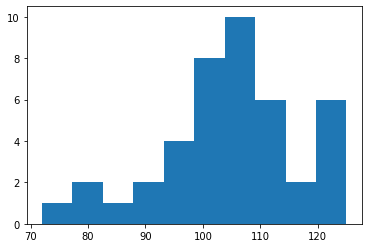

In [156]:
counter = Counter(X_train['subject#'])
plt.hist(counter.values())
plt.show()

* **Выводы:**

Можно заметить следующие факты:
    1. Все данные разделены на подгруппы по subject#. Причем в каждой подгруппе не менее 70 объектов
    2. Есть два категориальных признака: subject# и sex
    3. В этой задаче нужно предсказывать два таргета

* **План решения:**

    0.1 Заменяем категориальные признаки на one-hot представления
    0.2 Ищем оптимальные параметры для Ridge регрессии при помощи LOO валидации 

Далее план решения для каждого таргета будет следующим:
    1. Отбираем признаки при помощи SelectKBest
    3. Обучаем модель на нескольких бутстреповских выборках 

* Заменим категориальный признак *sex*

In [157]:
X_train, X_test = replace_categorial(X_train, X_test, ['subject#', 'sex'])

* Найдём оптимальные параметры Ridge регресси для каждого таргета

In [158]:
%%time
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

gs = RandomizedSearchCV(
    Ridge(),
    param_distributions={'alpha': sps.uniform(loc=0, scale=10)},
    cv=KFold(len(X_train_scaled)),
    scoring='neg_mean_squared_error',
    n_jobs=4,
    random_state=0,
    n_iter=10
)
gs.fit(X_train_scaled, y1_train)
print(f"Best alpha for first target = {gs.best_params_['alpha']}")
gs.fit(X_train_scaled, y2_train)
print(f"Best alpha for second target = {gs.best_params_['alpha']}")

Best alpha for first target = 3.8344151882577773
Best alpha for second target = 3.8344151882577773
CPU times: user 1min 23s, sys: 10.3 s, total: 1min 34s
Wall time: 2min 47s


* Исследуем сколько фичей нужно взять:

In [160]:
def RMSE(y_pred, y):
    return mean_squared_error(
        np.vstack([np.array(y1_pred), np.array(y2_pred)]),
        np.vstack([np.array(y1_train), np.array(y2_train)])
    )

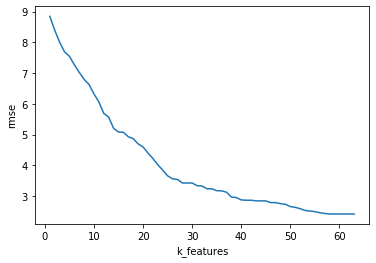

In [161]:
rmse_log = []
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model1 = Ridge(alpha=3.83)
model2 = Ridge(alpha=3.83)
for k_features in range(len(X_train.columns)):
    selecter = SelectKBest(f_regression, k_features+1)
    X1_train_cut = selecter.fit_transform(X_train_scaled, y1_train)
    X2_train_cut = selecter.fit_transform(X_train_scaled, y2_train)
    
    model1.fit(X1_train_cut, y1_train)
    model2.fit(X2_train_cut, y2_train)
    
    y1_pred = model1.predict(X1_train_cut)
    y2_pred = model2.predict(X2_train_cut)
    
    rmse_log.append(
        mean_squared_error(
            np.vstack([np.array(y1_pred), np.array(y2_pred)]),
            np.vstack([np.array(y1_train), np.array(y2_train)])
        ) ** 0.5
    )
    
plt.figure()
plt.xlabel('k_features')
plt.ylabel('rmse')
plt.plot(np.arange(1, len(X_train.columns)+1), rmse_log)
plt.show()

* **Вывод:**
Можем взять 55 фичей без большёй потери

* Опишем метод обучения

In [167]:
def fit_predict(X_train, y_train, X_test, y_column_name, k_features=55):
    """
    learn on X_train, y_train and predict y for train and test
    
    :param X_train: (pandas.Dataframe) train samples with id at first column
    :param y_train: (pandas.Series) train target
    :param X_test: (pandas.Dataframe) test samples with id at first column
    :param k_features: (int?) number of selecting features. All if None
    :return 
        y_pred_train: (pandas.Dataframe) with two columns (id, duration)
        y_pred_test: (pandas.Dataframe) with two columns (id, duration)
    """
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    selecter = SelectKBest(f_regression, k_features or 'all')
    X_train_cut = selecter.fit_transform(X_train_scaled, y_train)
    X_test_cut = selecter.transform(X_test_scaled)
    
    y_pred_train = np.zeros(len(X_train))
    y_pred_test = np.zeros(len(X_test))

    best_model = Ridge(alpha=3.83).fit(X_train_cut, y_train)
    
    y_pred_train = best_model.predict(X_train_cut)
    y_pred_test = best_model.predict(X_test_cut)
    
    y_pred_train_df = pd.DataFrame()
    y_pred_train_df['id'] = X_train.id
    y_pred_train_df[y_column_name] = y_pred_train
    
    y_pred_test_df = pd.DataFrame()
    y_pred_test_df['id'] = X_test.id
    y_pred_test_df[y_column_name] = y_pred_test
    
    return y_pred_train_df, y_pred_test_df

In [168]:
def fit_predict(X_train, y_train, X_test, y_column_name, k_features=20, n_samples=100):
    """
    learn on X_train, y_train and predict y for train and test
    
    :param X_train: (pandas.Dataframe) train samples with id at first column
    :param y_train: (pandas.Series) train target
    :param X_test: (pandas.Dataframe) test samples with id at first column
    :param k_features: (int?) number of selecting features. All if None
    :return 
        y_pred_train: (pandas.Dataframe) with two columns (id, duration)
        y_pred_test: (pandas.Dataframe) with two columns (id, duration)
    """
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    selecter = SelectKBest(f_regression, k_features or 'all')
    X_train_cut = selecter.fit_transform(X_train_scaled, y_train)
    X_test_cut = selecter.transform(X_test_scaled)
    
    y_pred_train = np.zeros(len(X_train))
    y_pred_test = np.zeros(len(X_test))
    
    for _ in range(n_samples):
        X_train_sampled, y_train_sampled = resample(X_train_cut, y_train, n_samples=5*len(X_train_cut))
        
        best_model = Ridge(alpha=3.83).fit(X_train_sampled, y_train_sampled)
        
        y_pred_train += best_model.predict(X_train_cut)
        y_pred_test += best_model.predict(X_test_cut)
        
    y_pred_train /= n_samples
    y_pred_test /= n_samples
    
    y_pred_train_df = pd.DataFrame()
    y_pred_train_df['id'] = X_train.id
    y_pred_train_df[y_column_name] = y_pred_train
    
    y_pred_test_df = pd.DataFrame()
    y_pred_test_df['id'] = X_test.id
    y_pred_test_df[y_column_name] = y_pred_test
    
    return y_pred_train_df, y_pred_test_df

In [169]:
def fit_pridict_multitarget(X_train, X_test, y, column_names):
    y_pred_train_df, y_pred_test_df = fit_predict(X_train, y[0], X_test, column_names[0])
    for i in range(1, len(y)):
        y_pred_train_df_curr, y_pred_test_df_curr = fit_predict(X_train, y[i], X_test, column_names[i])
        y_pred_train_df = y_pred_train_df.merge(y_pred_train_df_curr)
        y_pred_test_df = y_pred_test_df.merge(y_pred_test_df_curr)
#         return y_pred_train_df, y_pred_train_df_curr
    return y_pred_train_df, y_pred_test_df

* Evaluate

In [170]:
%%time
X_train_train, X_train_test, y1_train_train, y1_train_test, y2_train_train, y2_train_test = train_test_split(X_train, y1_train, y2_train, test_size=0.25)

y_pred_train, y_pred_test = fit_pridict_multitarget(X_train_train, X_train_test, [y1_train_train, y2_train_train], target_columns)
y_pred_train_pure, _ = fit_pridict_multitarget(X_train, X_test, [y1_train, y2_train], target_columns)

print('rmse on train is ', mean_squared_error(
    y_pred_train_pure[target_columns],
    np.vstack([np.array(y1_train), np.array(y2_train)]).T
)**0.5)
print('rmse on sub_train is ', mean_squared_error(
    y_pred_train[target_columns],
    np.vstack([np.array(y1_train_train), np.array(y2_train_train)]).T
)**0.5)
print('rmse on sub_test is ', mean_squared_error(
    y_pred_test[target_columns],
    np.vstack([np.array(y1_train_test), np.array(y2_train_test)]).T
)**0.5)

rmse on train is  4.596922618434227
rmse on sub_train is  4.4472822228081075
rmse on sub_test is  4.762947850111915
CPU times: user 7.51 s, sys: 149 ms, total: 7.66 s
Wall time: 1.95 s


* Отправка решения

In [171]:
y_pred_train, y_pred_test = fit_pridict_multitarget(X_train, X_test, [y1_train, y2_train], ['motor_UPDRS', 'total_UPDRS'])
ans = pd.concat([y_pred_train, y_pred_test]).sort_values('id')
ans.to_csv('kaggle_9_4.csv', index=False)
ans

,id,motor_UPDRS,total_UPDRS
747,1,32.019191,40.300044
0,2,31.959058,40.839043
143,3,31.901355,40.469010
1174,4,31.663341,40.676319
4360,5,31.848989,40.777048
...,...,...,...
124,5871,25.166747,32.228587
1285,5872,25.298043,32.248728
2799,5873,25.216033,32.486489
3335,5874,25.233202,32.412661


## Задача 5